# Generate the dataset
## We have 4 classes of 2D data points from each quadrant of the 2D plane
## We have an underltying functon that we would like top model, we do a symmetric sine function
## The dataset will have datapoints from each quadrant of the 2D plane sampled disproportionately
## The testing distributuion would be equivalent
## We will use 2 simple MLP's to model the function and the classifications


In [ ]:
!pip uninstall torch

In [18]:
# All declarations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

In [4]:
# All global variables

TRAIN_CLASS_SEGMENTS = [0.7,0.1,0.1,0.1]
CLASS_NAMES = ['0','1','2','3']
CLASS_COLORS = ['red','green','blue','yellow']
NDIM = 2
NSAMPLES = 1000
NCLASSES = len(CLASS_NAMES)
RANGE = [-2,2]
TRAIN_TEST_SPLIT = 0.8


In [31]:
# Creating a simple MLP

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, output_size=1,softmax = False):
        super(MLP, self).__init__()

        self.num_layers = num_layers

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(input_size, hidden_size))
        for i in range(self.num_layers):
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.Linear(hidden_size, hidden_size))

        self.layers.append(torch.nn.ReLU())
        self.layers.append(torch.nn.Linear(hidden_size, output_size))
        if softmax:
            self.layers.append(torch.nn.Softmax(dim=1))
        
        self.network = torch.nn.Sequential(*self.layers)
    
    def forward(self, x):
        return self.network(x)

In [13]:
#Generating data

x_data = np.random.random(size = (NSAMPLES,2)) * (RANGE[1] - RANGE[0]) + RANGE[0]
y_class = np.zeros((NSAMPLES,))


# Class 1
class1 = np.where(np.logical_and(x_data[:,0] > 0, x_data[:,1] > 0))[0]
y_class[class1] = 0

# Class 2
class2 = np.where(np.logical_and(x_data[:,0] < 0, x_data[:,1] > 0))[0]
y_class[class2] = 1

# Class 3
class3 = np.where(np.logical_and(x_data[:,0] < 0, x_data[:,1] < 0))[0]
y_class[class3] = 2

# Class 4
class4 = np.where(np.logical_and(x_data[:,0] > 0, x_data[:,1] < 0))[0]
y_class[class4] = 3

# Underlying function is a gaussian distribution
y_labels = np.exp(-0.03*np.sum(x_data**2, axis = 1))


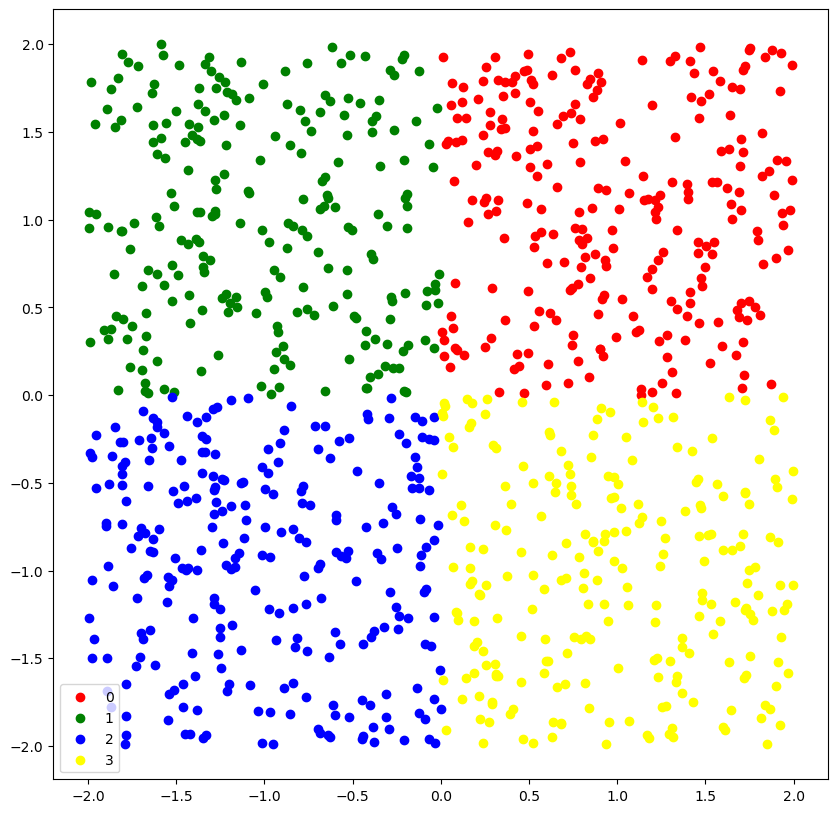

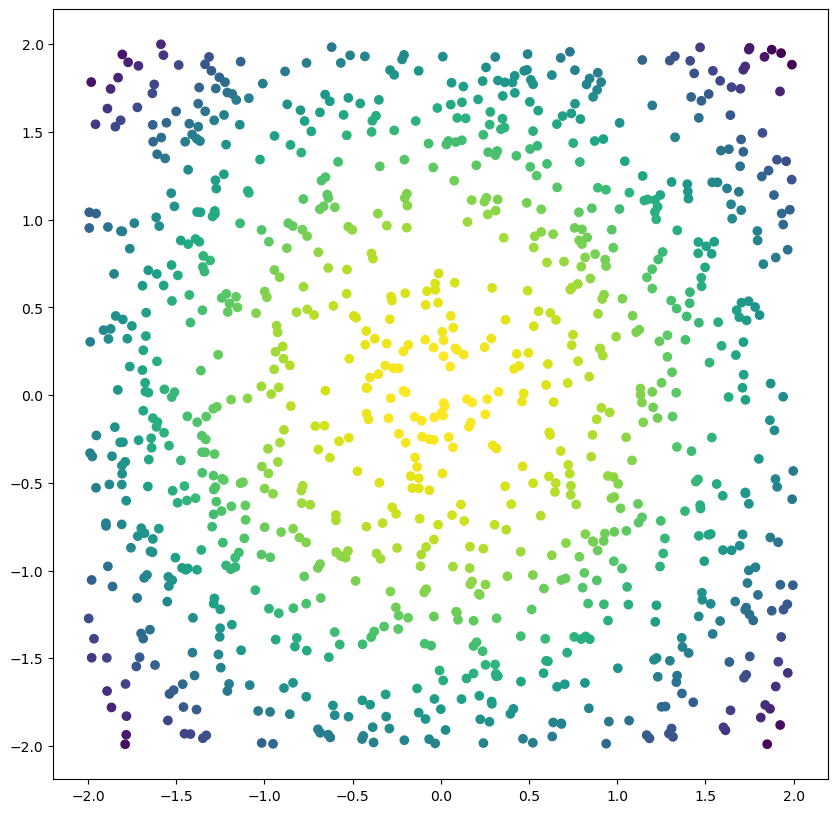

In [14]:
# Visualizing the data

plt.figure(figsize = (10,10))   
for i in range(NCLASSES):
    plt.scatter(x_data[y_class == i,0], x_data[y_class == i,1], c = CLASS_COLORS[i], label = CLASS_NAMES[i])
plt.legend()
plt.savefig('Dataclass.png')

# Visualizing the underlying function

plt.figure(figsize = (10,10))
plt.scatter(x_data[:,0], x_data[:,1], c = y_labels)
plt.savefig('Datafunc.png')

In [38]:
# Train test split 

train_test_split = int(TRAIN_TEST_SPLIT * NSAMPLES)
x_train, x_test = x_data[:train_test_split,:], x_data[train_test_split:,:]
y_class_train, y_class_test = y_class[:train_test_split], y_class[train_test_split:]
y_labels_train, y_labels_test = y_labels[:train_test_split], y_labels[train_test_split:]

# Creating the torch tensors

x_train = torch.tensor(x_train, dtype = torch.float32)
x_test = torch.tensor(x_test, dtype = torch.float32)
y_class_train = torch.tensor(y_class_train, dtype = torch.int64)
y_class_test = torch.tensor(y_class_test, dtype = torch.int64)
# Create one hot encoding for the class labels
y_class_train = torch.nn.functional.one_hot(y_class_train, num_classes = NCLASSES).float()
y_class_test = torch.nn.functional.one_hot(y_class_test, num_classes = NCLASSES).float()

y_labels_train = torch.tensor(y_labels_train, dtype = torch.float32)
y_labels_test = torch.tensor(y_labels_test, dtype = torch.float32)

print(x_train.shape, x_test.shape, y_class_train.shape, y_class_test.shape, y_labels_train.shape, y_labels_test.shape)

# Create the training and validation dataloaders from the torch tensors

train_dataset = torch.utils.data.TensorDataset(x_train, y_class_train,y_labels_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

val_dataset = torch.utils.data.TensorDataset(x_test, y_class_test,y_labels_test)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 32, shuffle = True)

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800, 4]) torch.Size([200, 4]) torch.Size([800]) torch.Size([200])


In [43]:
# Pytorch lightning module to train the models
#impor trace

from pdb import set_trace

class classTrainer(pl.LightningModule):

    # Declare the class models and the function models
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.model = MLP(input_size, hidden_size, output_size = output_size, num_layers = 3, softmax = True)
        self.func_model = MLP(input_size, hidden_size, output_size = 1, num_layers =3)
        self.loss = torch.nn.CrossEntropyLoss()
        self.funv_loss = torch.nn.MSELoss()
    
    def forward(self, x):
        return (self.model(x), self.func_model(x))
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y_class, y_labels = batch
        y_pred_class, y_pred_labels = self.forward(x)
        loss_class = self.loss(y_pred_class, y_class)
        set_trace()
        loss_func = self.funv_loss(y_pred_labels, y_labels.unsqueeze(1))
        loss = loss_class + loss_func
        self.log('train_loss_class', loss_class.detach(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_loss_func', loss_func.detach(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y_class, y_labels = batch
        y_pred_class, y_pred_labels = self.forward(x)
        loss_class = self.loss(y_pred_class, y_class)
        loss_func = self.funv_loss(y_pred_labels, y_labels.unsqueeze(1))
        loss = loss_class + loss_func
        self.log('val_loss_class', loss_class.detach(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_loss_func', loss_func.detach(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def return_model_weights(self):
        return [self.model.state_dict(), self.func_model.state_dict()] 


# Training the model
model = classTrainer(input_size=2,
                       hidden_size=128,
                        output_size=4)
trainer = pl.Trainer(max_epochs=100, devices=2, accelerator='gpu')

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
[W socket.cpp:426] [c10d] The server socket has failed to bind to [::]:34527 (errno: 98 - Address already in use).
[W socket.cpp:426] [c10d] The server socket has failed to bind to ?UNKNOWN? (errno: 98 - Address already in use).
[E socket.cpp:462] [c10d] The server socket has failed to listen on any local network address.


ProcessRaisedException: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/torch/multiprocessing/spawn.py", line 69, in _wrap
    fn(i, *args)
  File "/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 149, in _wrapping_function
    results = function(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py", line 571, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py", line 938, in _run
    self.strategy.setup_environment()
  File "/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/pytorch_lightning/strategies/ddp.py", line 143, in setup_environment
    self.setup_distributed()
  File "/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/pytorch_lightning/strategies/ddp.py", line 192, in setup_distributed
    _init_dist_connection(self.cluster_environment, self._process_group_backend, timeout=self._timeout)
  File "/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/lightning_fabric/utilities/distributed.py", line 258, in _init_dist_connection
    torch.distributed.init_process_group(torch_distributed_backend, rank=global_rank, world_size=world_size, **kwargs)
  File "/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/torch/distributed/distributed_c10d.py", line 900, in init_process_group
    store, rank, world_size = next(rendezvous_iterator)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/torch/distributed/rendezvous.py", line 245, in _env_rendezvous_handler
    store = _create_c10d_store(master_addr, master_port, rank, world_size, timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/torch/distributed/rendezvous.py", line 176, in _create_c10d_store
    return TCPStore(
           ^^^^^^^^^
RuntimeError: The server socket has failed to listen on any local network address. The server socket has failed to bind to [::]:34527 (errno: 98 - Address already in use). The server socket has failed to bind to ?UNKNOWN? (errno: 98 - Address already in use).
